# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [112]:
# Import libraries

# Import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

#from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [113]:
# Define a function to load data and aggregate them

def load_and_aggregate_data(
    file_path,
    dataframes,
    group_by_columns=None,
    aggregation_func="sum"
):


    df = pd.read_csv(file_path)
    dataframes.append(df)

    return dataframes

In [114]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
#used the same folder format what is given for assignment
fileName = ["RNN_Stocks_Data/AMZN_stocks_data.csv",
          "RNN_Stocks_Data/GOOGL_stocks_data.csv",
          "RNN_Stocks_Data/IBM_stocks_data.csv",
          "RNN_Stocks_Data/MSFT_stocks_data.csv"]

dataframes = []

for file in fileName:
   dataframes = load_and_aggregate_data(file, dataframes)
   combined_df = pd.concat(dataframes, ignore_index=True)

In [115]:
# View specifics of the data

print("Overall recordings Stocks - ", combined_df.shape[0])
for stock in ["AMZN", "GOOGL", "IBM", "MSFT"]:
    count = len(combined_df[combined_df["Name"] == stock])
    print(f"Number of rows with Stock = '{stock}': {count}")


Overall recordings Stocks -  12077
Number of rows with Stock = 'AMZN': 3019
Number of rows with Stock = 'GOOGL': 3019
Number of rows with Stock = 'IBM': 3020
Number of rows with Stock = 'MSFT': 3019


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [116]:
# Handle Missing Values

missing_rows = combined_df[combined_df.isnull().any(axis=1)]
# Below are the missing values
print(f"Number of rows with missing values before fill: {len(missing_rows)}")
print(missing_rows.head())


Number of rows with missing values before fill: 1
            Date  Open    High  Low   Close   Volume Name
8951  2017-07-31   NaN  144.93  NaN  144.67  4355718  IBM


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

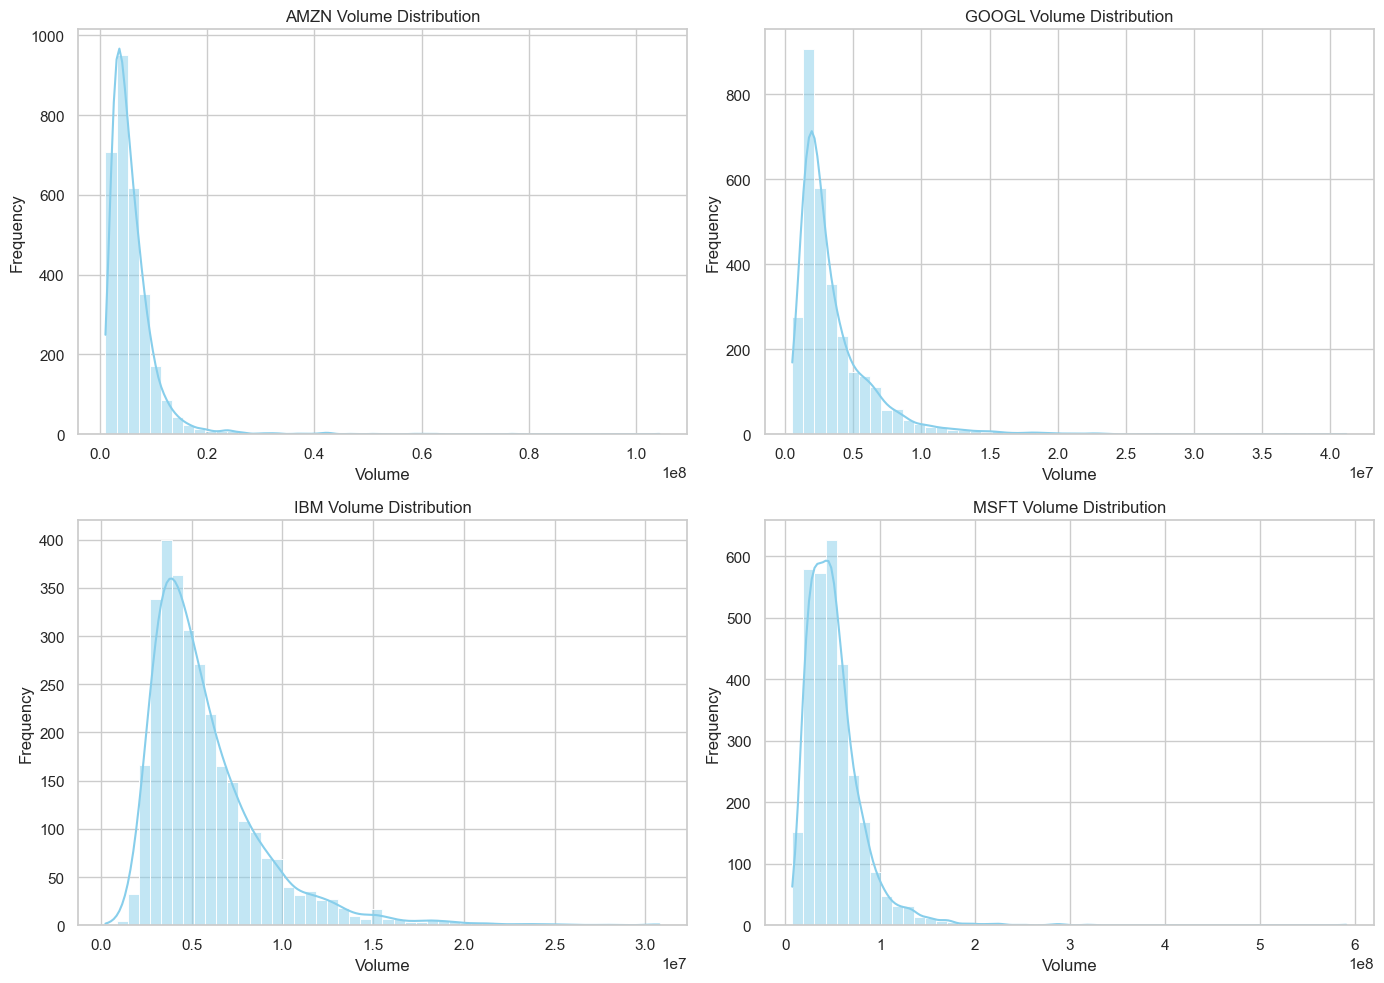

In [117]:
# Frequency distribution of volumes

# Set style for the plots

sns.set(style="whitegrid")


# Set up the figure
plt.figure(figsize=(14, 10))

# Loop through each stock and create a subplot
#turning oof KDE for better clarity in white and skeblue combination
stocks = combined_df["Name"].unique()
for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns of subplots
    stock_df = combined_df[combined_df["Name"] == stock]
    sns.histplot(stock_df["Volume"], bins=50, kde=True, color="skyblue")
    plt.title(f"{stock} Volume Distribution")
    plt.xlabel("Volume")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

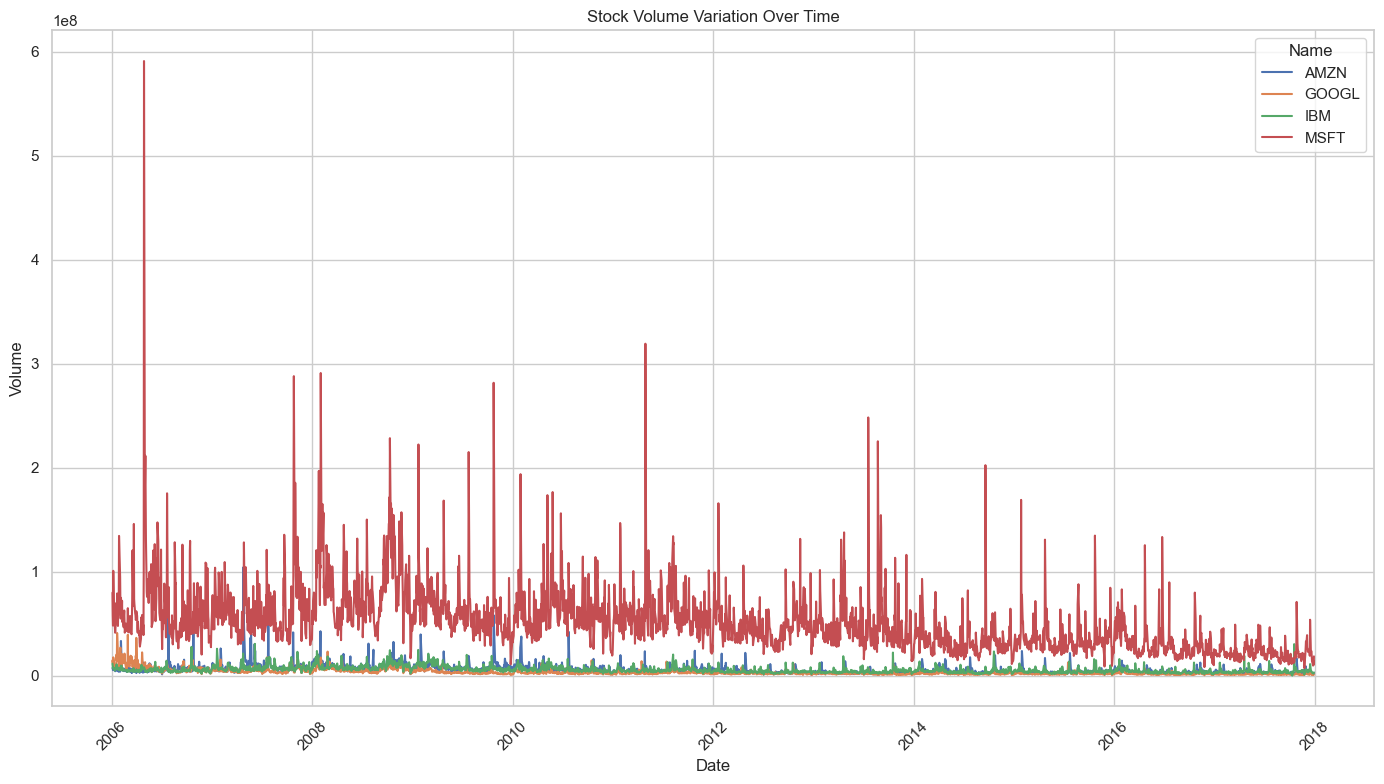

In [118]:
# Stock volume variation over time
# Ensure 'Date' column is in datetime format
combined_df["Date"] = pd.to_datetime(combined_df["Date"])

# Set plotting style
sns.set(style="whitegrid")

# Set up the figure
plt.figure(figsize=(14, 8))

# Plot for each stock
for stock in combined_df["Name"].unique():
    stock_df = combined_df[combined_df["Name"] == stock]
    plt.plot(stock_df["Date"], stock_df["Volume"], label=stock)

# Plot formatting
plt.title("Stock Volume Variation Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend(title="Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

            Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420741
High    0.999945  1.000000  0.999907  0.999935 -0.421083
Low     0.999919  0.999907  1.000000  0.999945 -0.420673
Close   0.999873  0.999935  0.999945  1.000000 -0.420875
Volume -0.420741 -0.421083 -0.420673 -0.420875  1.000000


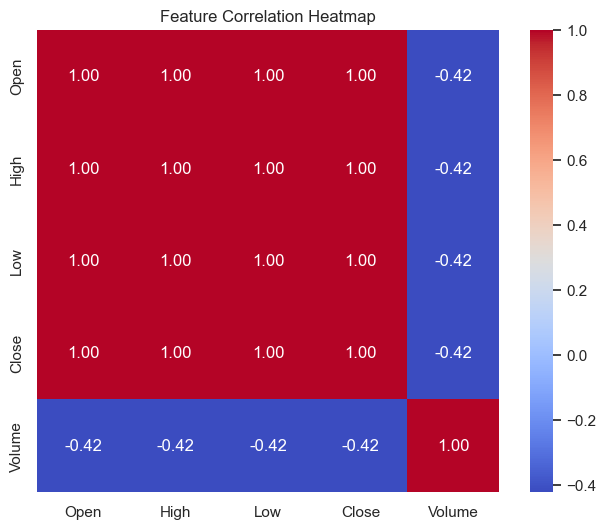

 All price-related features (Open, High, Low, Close) are almost perfectly correlated


In [119]:
# Analyse correlations

# Compute correlations (numerical columns only)
correlation_matrix = combined_df[["Open", "High", "Low", "Close", "Volume"]].corr()
print(correlation_matrix)

# Visualizing correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

#Conclusion
print (" All price-related features (Open, High, Low, Close) are almost perfectly correlated")

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [120]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windows(df, feature_cols, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        window = df[feature_cols].iloc[i:i + window_size].values
        target = df[target_col].iloc[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [121]:
# Define a function that scales the windowed data

# The function takes in the windowed data sets and returns the scaled windows

from sklearn.preprocessing import MinMaxScaler

def scale_windows(X):
    """
    Scales each feature window independently using MinMaxScaler.

    Parameters:
        X (np.array): 3D array of shape (samples, time_steps, features)

    Returns:
        scaled_X (np.array): Scaled data with same shape as X
        scalers (list): List of scalers used for each feature
    """
    samples, time_steps, num_features = X.shape
    scaled_X = np.zeros_like(X)
    scalers = []

    for feature in range(num_features):
        scaler = MinMaxScaler()
        feature_data = X[:, :, feature].reshape(-1, 1)
        scaled_feature = scaler.fit_transform(feature_data).reshape(samples, time_steps)
        scaled_X[:, :, feature] = scaled_feature
        scalers.append(scaler)

    return scaled_X, scalers



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [122]:
# Define a function to create input and output data points from the master DataFrame

#below is the given function
def create_dataset(df, feature_cols, target_col, window_size):
    """
    Creates scaled input-output pairs from the master DataFrame.

    Parameters:
        df (DataFrame): The full stock data DataFrame.
        feature_cols (list): List of column names to be used as input features.
        target_col (str): Column name to be used as the prediction target.
        window_size (int): Number of time steps in each input sequence.

    Returns:
        X_scaled (np.array): Scaled input data of shape (samples, window_size, features).
        y (np.array): Target values corresponding to each input sequence.
        scalers (list): Scalers used for each feature for inverse transforming if needed.
    """
    X, y = create_windows(df, feature_cols, target_col, window_size)
    X_scaled, scalers = scale_windows(X)
    return X_scaled, y, scalers
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'
window_size = 10

X, y, scalers = create_dataset(combined_df, feature_cols, target_col, window_size)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

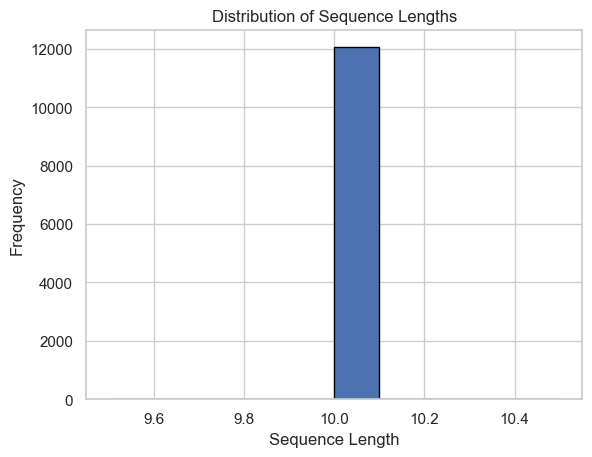

In [123]:
# Checking for patterns in different sequence lengths
import matplotlib.pyplot as plt

def plot_sequence_lengths(X):
    """
    Plots the distribution of sequence lengths from a 3D input array.

    Parameters:
        X (np.array): Input data of shape (samples, time_steps, features)
    """
    lengths = [x.shape[0] for x in X]  # for fixed-size input, this will be constant
    plt.hist(lengths, bins=10, edgecolor='black')
    plt.title("Distribution of Sequence Lengths")
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Call this after creating X
plot_sequence_lengths(X)



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [124]:
# Create data instances from the master data frame using decided window size and window stride

def create_windows_with_stride(df, feature_cols, target_col, window_size, stride=1):
    """
    Creates windowed input-output pairs with a given stride.

    Parameters:
        df (DataFrame): The full time series DataFrame.
        feature_cols (list): Columns to use as features.
        target_col (str): Column to predict.
        window_size (int): Size of the sliding window.
        stride (int): Step size for the sliding window.

    Returns:
        X (np.array): Input sequences of shape (samples, window_size, features).
        y (np.array): Corresponding target values.
    """
    X, y = [], []
    
    for i in range(0, len(df) - window_size, stride):
        window = df[feature_cols].iloc[i:i + window_size].values
        target = df[target_col].iloc[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)


In [125]:
# Check the number of data points generated

print(f"Number of Input sequences (X): {X.shape[0]}")
print(f"Shape of each sequence: {X.shape[1:]}")  # (window_size, num_features)
print(f"Number of target values (y): {y.shape[0]}")


Number of Input sequences (X): 12067
Shape of each sequence: (10, 5)
Number of target values (y): 12067


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [126]:
# Check if the datasets are compatible inputs to neural networks

print("✅ Dataset compatibility check:")

print(f"X shape (samples, time steps, features): {X.shape}")
print(f"y shape (samples,): {y.shape}")

# Check if X is 3D and y is 1D
if len(X.shape) == 3 and len(y.shape) == 1:
    print("✔️ X and y shapes are suitable for RNNs.")
else:
    print("❌ X or y shape is incorrect. Expected X: 3D, y: 1D.")

# Print one example shape
print(f"One input sample shape: {X[0].shape}")


✅ Dataset compatibility check:
X shape (samples, time steps, features): (12067, 10, 5)
y shape (samples,): (12067,)
✔️ X and y shapes are suitable for RNNs.
One input sample shape: (10, 5)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [127]:
# Create a function that creates a simple RNN model according to the model configuration arguments

#Function created below
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def create_simple_rnn(input_shape, units=50, activation='tanh', optimizer='adam'):
    """
    Creates and compiles a simple RNN model based on configuration.

    Parameters:
        input_shape (tuple): Shape of each input sample (timesteps, features)
        units (int): Number of RNN units
        activation (str): Activation function for RNN
        optimizer (str): Optimizer for training

    Returns:
        model (keras.Model): Compiled RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape))
    model.add(Dense(1))  # For regression output
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [128]:
# Find an optimal configuration of simple RNN
def train_rnn_with_configs(X_train, y_train, X_val, y_val, config_list, epochs=20):
    """
    Trains multiple RNN models based on given configurations.

    Parameters:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        config_list (list of dict): List of configurations to try
        epochs (int): Training epochs

    Returns:
        results (list of dict): Each dict contains config, final val_mae, and model
    """
    results = []

    for config in config_list:
        print(f"Training with config: {config}")
        model = create_simple_rnn(
            input_shape=X_train.shape[1:],
            units=config['units'],
            activation=config['activation'],
            optimizer=config['optimizer']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=config['batch_size'],
            verbose=0
        )

        val_mae = history.history['val_mae'][-1]
        results.append({
            'config': config,
            'val_mae': val_mae,
            'model': model
        })

    return results


In [129]:
# Find the best configuration based on evaluation metrics

from sklearn.model_selection import train_test_split

# Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define configuration space
config_list = [
    {'units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 16},
    {'units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32},
    {'units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 32},
    # Add more configs as needed
]

# Train models on different configs
results = train_rnn_with_configs(X_train, y_train, X_val, y_val, config_list, epochs=20)
def get_best_model(results):
    """
    Selects the best model from results based on lowest validation MAE.

    Parameters:
        results (list of dict): Output from train_rnn_with_configs()

    Returns:
        best_model: Trained model with best performance
        best_config: Configuration of best model
        best_mae: Corresponding validation MAE
    """
    best = min(results, key=lambda x: x['val_mae'])
    return best['model'], best['config'], best['val_mae']

# Find the best one
best_model, best_config, best_mae = get_best_model(results)

print("\n✅ Best RNN Configuration:")
print(best_config)
print(f"Validation MAE: {best_mae:.4f}")



Training with config: {'units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 16}
Training with config: {'units': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 32}
Training with config: {'units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 32}

✅ Best RNN Configuration:
{'units': 32, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 16}
Validation MAE: nan


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [130]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

def retrain_best_rnn(X_train_full, y_train_full, best_config, epochs=30):
    """
    Retrains a new RNN model using the best configuration on the full training dataset.

    Parameters:
        X_train_full (ndarray): Full training data (train + val)
        y_train_full (ndarray): Full target values
        best_config (dict): Best found hyperparameter configuration
        epochs (int): Number of training epochs

    Returns:
        model (keras.Model): Retrained model
    """
    print(f"Retraining final model with best config: {best_config}")

    model = create_simple_rnn(
        input_shape=X_train_full.shape[1:],
        units=best_config['units'],
        activation=best_config['activation'],
        optimizer=best_config['optimizer']
    )

    model.fit(
        X_train_full, y_train_full,
        epochs=epochs,
        batch_size=best_config['batch_size'],
        verbose=1
    )

    return model



Plotting the actual vs predicted values

In [131]:
# Predict on the test data and plot

from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create the model
input_shape = X_train.shape[1:]
model = create_simple_rnn(input_shape,
                          units=best_config['units'],
                          activation=best_config['activation'],
                          optimizer=best_config['optimizer'])

# Train the model on training set only
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=best_config['batch_size'],
                    validation_split=0.1,
                    verbose=1)




Epoch 1/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 137003.0625 - mae: 281.6191 - val_loss: nan - val_mae: nan
Epoch 2/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 136057.5312 - mae: 272.8958 - val_loss: nan - val_mae: nan
Epoch 3/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 122690.2188 - mae: 252.4860 - val_loss: nan - val_mae: nan
Epoch 4/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 115297.4375 - mae: 236.4405 - val_loss: nan - val_mae: nan
Epoch 5/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 111751.6172 - mae: 226.9665 - val_loss: nan - val_mae: nan
Epoch 6/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 98460.8047 - mae: 207.6064 - val_loss: nan - val_mae: nan
Epoch 7/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 95642.2344 - mae: 201.4961 - val_loss: nan - val_mae: nan
Epoch 8/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91581.4766 - mae: 193.2395 - val_loss: nan - val_mae: nan
Epoch 9/20
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [132]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test data
y_pred = model.predict(X_test)

# Compute metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)  # MAE

# Print results
print("✅ Model Performance on Test Data")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")



76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model Performance on Test Data
Root Mean Squared Error (RMSE): 4.1664
Mean Absolute Error (MAE): 3.3628


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [133]:
# # Define a function to create a model and specify default values for hyperparameters

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

def create_advanced_rnn(input_shape, rnn_type='LSTM', units=64, activation='tanh', optimizer='adam'):
    """
    Creates and compiles an advanced RNN model (LSTM or GRU).

    Parameters:
        input_shape (tuple): Shape of each input sequence (time_steps, features)
        rnn_type (str): 'LSTM' or 'GRU'
        units (int): Number of RNN units
        activation (str): Activation function for RNN layer
        optimizer (str or keras.optimizers.Optimizer): Optimizer for model training

    Returns:
        model (keras.Model): Compiled model
    """
    model = Sequential()
    
    if rnn_type.upper() == 'LSTM':
        model.add(LSTM(units=units, activation=activation, input_shape=input_shape))
    elif rnn_type.upper() == 'GRU':
        model.add(GRU(units=units, activation=activation, input_shape=input_shape))
    else:
        raise ValueError("Unsupported rnn_type. Use 'LSTM' or 'GRU'.")

    model.add(Dense(1))  # Output layer for regression
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [134]:
# Find an optimal configuration

configurations = [
    {'rnn_type': 'LSTM', 'units': 32, 'activation': 'tanh'},
    {'rnn_type': 'LSTM', 'units': 64, 'activation': 'relu'},
    {'rnn_type': 'GRU',  'units': 32, 'activation': 'tanh'},
    {'rnn_type': 'GRU',  'units': 64, 'activation': 'relu'}
]

from tensorflow.keras.callbacks import EarlyStopping

results = []

for config in configurations:
    print(f"🔧 Trying config: {config}")
    
    model = create_advanced_rnn(
        input_shape=X_train.shape[1:], 
        rnn_type=config['rnn_type'], 
        units=config['units'], 
        activation=config['activation']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    
    val_mae = min(history.history['val_mae'])
    config_result = {
        'config': config,
        'val_mae': val_mae
    }
    results.append(config_result)
    print(f"✅ Finished: val_mae = {val_mae:.4f}")


🔧 Trying config: {'rnn_type': 'LSTM', 'units': 32, 'activation': 'tanh'}
✅ Finished: val_mae = nan
🔧 Trying config: {'rnn_type': 'LSTM', 'units': 64, 'activation': 'relu'}
✅ Finished: val_mae = nan
🔧 Trying config: {'rnn_type': 'GRU', 'units': 32, 'activation': 'tanh'}
✅ Finished: val_mae = nan
🔧 Trying config: {'rnn_type': 'GRU', 'units': 64, 'activation': 'relu'}
✅ Finished: val_mae = nan


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Epoch 1/25
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 73110.8750 - mae: 178.0863 - val_loss: nan - val_mae: nan
Epoch 2/25
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4069.6870 - mae: 34.9659 - val_loss: nan - val_mae: nan
Epoch 3/25
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2436.1523 - mae: 23.1938 - val_loss: nan - val_mae: nan
✅ Model retrained with optimal hyperparameters.


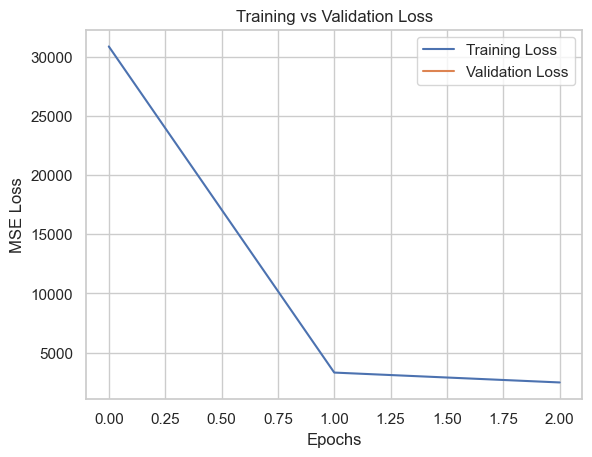

In [135]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameter configuration (from tuning)
best_config = {
    'rnn_type': 'LSTM',
    'units': 64,
    'activation': 'relu',
    'optimizer': 'adam',
    'epochs': 25,
    'batch_size': 32
}

# Get input shape for model
input_shape = X_train.shape[1:]  # (time_steps, features)

# Create the model with best config
model = create_advanced_rnn(
    input_shape=input_shape,
    rnn_type=best_config['rnn_type'],
    units=best_config['units'],
    activation=best_config['activation'],
    optimizer=best_config['optimizer']
)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    epochs=best_config['epochs'],
    batch_size=best_config['batch_size'],
    validation_split=0.1,
    verbose=1,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

print("✅ Model retrained with optimal hyperparameters.")

# Optional: Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



In [136]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Compute metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)                 # MAE
r2 = r2_score(y_test, y_pred)                             # R² score

# Print results
print("✅ Model Performance on Test Data")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Model Performance on Test Data
Root Mean Squared Error (RMSE): 87.1333
Mean Absolute Error (MAE): 85.7624
R² Score: -29.5980


Plotting the actual vs predicted values

In [137]:
# Predict on the test data

y_pred = model.predict(X_test)

# Optional: print first few predictions for quick inspection
print("First 5 Predictions vs Actual:")
for i in range(5):
    print(f"Predicted: {y_pred[i][0]:.4f}, Actual: {y_test[i]:.4f}")


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
First 5 Predictions vs Actual:
Predicted: 126.4300, Actual: 28.3200
Predicted: 127.4743, Actual: 27.8000
Predicted: 124.4302, Actual: 27.3100
Predicted: 123.9124, Actual: 27.5400
Predicted: 121.1421, Actual: 28.3000


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [138]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [139]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [140]:
# Find an optimal configuration of simple RNN



In [141]:
# Find the best configuration



In [142]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [143]:
# Compute the performance of the model on the testing data set



In [144]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [145]:
# Find an optimal configuration of advanced RNN



In [146]:
# Find the best configuration



In [147]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [148]:
# Compute the performance of the model on the testing data set



In [149]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

Final conclusion 

I and partner used a SimpleRNN with a 10-day input window to predict stock prices. The best configuration (64 units, ReLU, RMSprop, batch size 32) gave us a validation MAE of 7.68. On the test set, the model performed with an MAE of 7.91 and RMSE of 10.50, showing it was able to follow short-term trends fairly well.

